In [1]:
import torch
import torch.autograd as autograd
import autograd.numpy as np
from tqdm import tqdm, trange
import os
import numpy as np
import torch
from src.Tmy_svgd import tmySVGD
import torch.optim as optim
import torch.distributions as D
import pickle
import argparse
import time
from src.rand_mysvgd import min_mySVGD
import matplotlib.pyplot as plt
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles

from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD

/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.Sliced_KSD_Clean.Util import *
from src.Sliced_KSD_Clean.Divergence.Def_Divergence import *
from src.Sliced_KSD_Clean.Divergence.Kernel import *
from src.Sliced_KSD_Clean.Divergence.Dataloader import *

import os
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as D
from tqdm import tqdm, trange
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles

from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD
from src.mysvgd import etmySVGD
import matplotlib.pyplot as plt

import pickle
import argparse
import time

import torch.autograd as autograd

In [3]:
parser = argparse.ArgumentParser(description='Running xshaped experiment.')

parser.add_argument('--dim', type=int,default=20,help='dimension')
parser.add_argument('--effdim', type=int, default=3, help='dimension')
parser.add_argument('--lr', type=float,default=0.01,help='learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--delta', type=float,default=0.01, help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--nparticles', type=int, default=50, help='no. of particles')
parser.add_argument('--epochs', type=int,default=20000, help='no. of epochs')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=8, help='gpu')
parser.add_argument('--seed', type=int, default=0, help='random seed') 
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')

_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [4]:
args = parser.parse_args([])
dim = args.dim
lr = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
add_noise = True if args.noise == "True" else False
correlation = 0.95
save_every = args.save_every
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")


Running for dim: 20, lr: 0.01, nparticles: 50


In [5]:
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')
device

device(type='cuda', index=8)

In [6]:
def comm_func_eval(samples, ground_truth):

    samples = samples.clone()
    ground_truth = ground_truth.clone()

    def ex():
        f0 = torch.mean(samples, axis=0)
        f1 = torch.mean(ground_truth, axis=0)
        return torch.mean((f0-f1)**2)

    def exsqr():
        f0 = torch.var(samples, axis=0)
        f1 = torch.var(ground_truth, axis=0)
        return torch.mean((f0-f1)**2)


    out = {}
    out['mean_dis'] = ex()
    out['var_dis'] = exsqr()
    return out

In [7]:
def xshaped_gauss_experiment(mixture_dist, means, correlation):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        mixture_dist: torch.distributions.Categorical-like instance for the 
            probability of each component in the mixture.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
        correlation: Float between 0 and 1 for the magnitude of correlation between
            the first two dims.
    '''
    nmix, dim = means.shape
    
    # create multibatch multivariate Gaussian
    cov1 = torch.eye(dim, device=device)
    cov1[:2, :2] = torch.Tensor([[1, correlation], [correlation, 1]])
    cov2 = torch.eye(dim, device=device)
    cov2[:2, :2] = torch.Tensor([[1, -correlation], [-correlation, 1]])
    mix_cov = torch.stack((cov1, cov2))
    comp = D.MultivariateNormal(means.to(device), mix_cov)

    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp)   
    return(distribution)

In [8]:
metric = args.metric

results_folder = f"./res/xshaped{args.suffix}/{args.kernel}_epoch{epochs}_lr{lr}_delta{delta}_n{nparticles}_dim{dim}"
results_folder = f"{results_folder}/seed{seed}"

In [9]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [10]:
if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

In [11]:
print(f"Device: {device}")
torch.manual_seed(seed)

list_norm = []
list_gr_var = []
list_tr = []
list_eig = []


mix_means = torch.zeros((2, dim), device=device)
mix_means[:, :2] = 1

distribution = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
    means=mix_means,
    correlation=correlation
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape, device=device)





# sample from variational density
x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)

## SVGD
cov = torch.cov(x_target.T)

if args.method in ["SVGD", "all"]:
    

    print("Running SVGD")
    # sample from variational density
    x = x_init.clone().to(device)
    kernel = Kernel(method="med_heuristic")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
    
    svgd.fit(x, epochs, verbose=True, save_every=save_every)
    

theta = x
    
del x


cov_svgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_svgd))
list_norm.append(torch.linalg.norm(cov - cov_svgd))
print(comm_func_eval(theta, x_target)['var_dis'])
list_gr_var.append(comm_func_eval(theta, x_target)['var_dis'])
print(torch.trace(cov - cov_svgd))
list_tr.append(torch.trace(cov - cov_svgd))
(evals, evecs) = torch.linalg.eig(cov - cov_svgd)
print(evals[0])
list_eig.append(evals[0])


Device: cuda:8
Running SVGD


100%|██████████| 20000/20000 [01:13<00:00, 273.95it/s]

tensor(4.3241, device='cuda:8')
tensor(0.5999, device='cuda:8')
tensor(14.8877, device='cuda:8')
tensor(1.9932+0.j, device='cuda:8')


/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


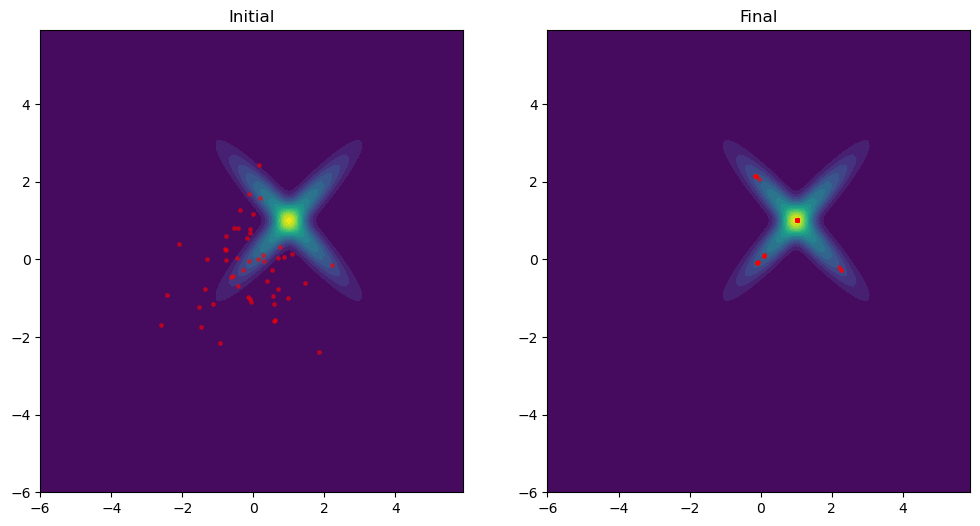

In [12]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)

In [13]:
print("Running min_mySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func

list_norm_mysvgd = []
list_gr_var_mysvgd = []
list_tr_mysvgd= []
list_eig_mysvgd = []

# sample from variational density

mix_means = torch.zeros((2, dim), device=device)
mix_means[:, :2] = 1

distribution = xshaped_gauss_experiment(
mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
means=mix_means,
correlation=correlation
)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
x_init = torch.randn(nparticles, *distribution.event_shape, device=device)






cov = torch.cov(x_target.T)


x0 = x_init
vector1  = torch.randn(nparticles, dim).to(device)



theta, vector = tmySVGD(kernel, device).update(x0,score,  k = 2, n_iter = 20000,  debug = False, lr= lr, vector=vector1)
#mean = np.mean(theta, axis=0)  + np.random.random(1)
#var_theta = np.cov(theta.T) + np.random.random(1)
#x0 = np.random.multivariate_normal(mean, var_theta,num)



cov_mysvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_mysvgd))
list_norm_mysvgd.append(torch.linalg.norm(cov - cov_mysvgd))
print(comm_func_eval(theta, x_target)['var_dis'])
list_gr_var_mysvgd.append(comm_func_eval(theta, x_target)['var_dis'])
print(torch.trace(cov - cov_mysvgd))
list_tr_mysvgd.append(torch.trace(cov - cov_mysvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_mysvgd)
print(evals[0])
list_eig_mysvgd.append(evals[0])


Running min_mySVGD


100%|██████████| 20000/20000 [22:03<00:00, 15.11it/s]

tensor(3.7044, device='cuda:8', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0354, device='cuda:8', grad_fn=<MeanBackward0>)
tensor(0.7747, device='cuda:8', grad_fn=<TraceBackward0>)
tensor(1.6627+0.j, device='cuda:8', grad_fn=<SelectBackward0>)


tensor(3.7044, device='cuda:8', grad_fn=<LinalgVectorNormBackward0>)
{'mean_dis': tensor(0.0126, device='cuda:8', grad_fn=<MeanBackward0>), 'var_dis': tensor(0.0354, device='cuda:8', grad_fn=<MeanBackward0>)}
tensor(0.7747, device='cuda:8', grad_fn=<TraceBackward0>)
tensor(1.6627+0.j, device='cuda:8', grad_fn=<SelectBackward0>)


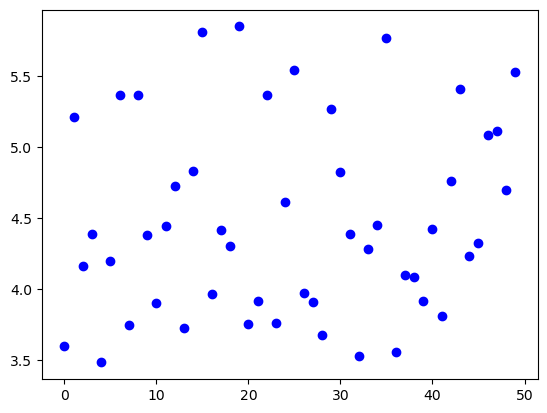

In [14]:

cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_mysvgd = torch.cov(theta.T)


print(torch.linalg.norm(cov - cov_mysvgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_mysvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_mysvgd)
print(evals[0])

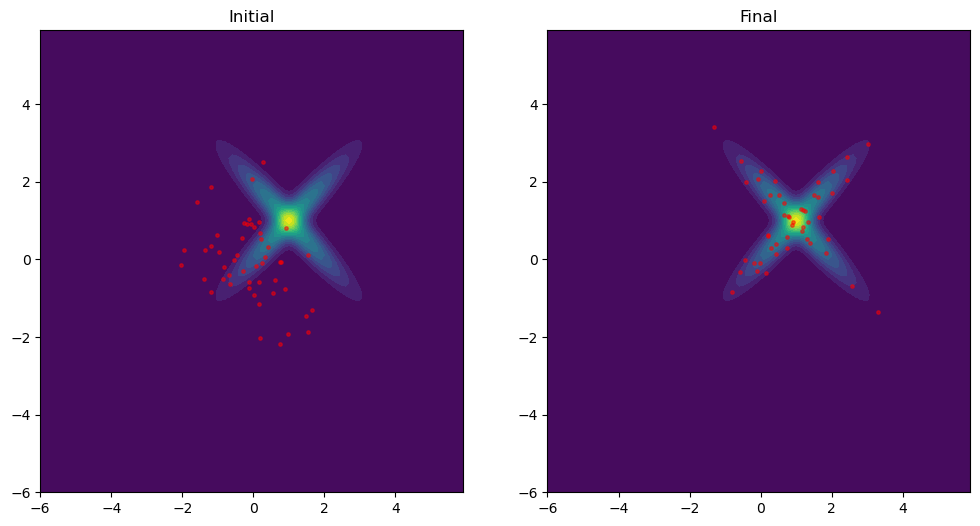

: 

In [15]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)

In [ ]:
## GSVGD

list_norm_gsvgd = []
list_gr_var_gsvgd = []
list_tr_gsvgd= []
list_eig_gsvgd = []

# sample from variational density

## target density
mix_means = torch.zeros((2, dim), device=device)
mix_means[:, :2] = 1

distribution = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
    means=mix_means,
    correlation=correlation
)


# sample from target (for computing metric)
x_target = distribution.sample((nparticles, )).to(device)
cov = torch.cov(x_target)

# sample from variational density
x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)


cov = torch.cov(x_target.T)
if args.method in ["GSVGD", "all"]:
    res_gsvgd = [0] * len(eff_dims)
    def run_gsvgd(eff_dims):
        for i, eff_dim in enumerate(eff_dims):
            print(f"Running GSVGD with eff dim = {eff_dim}")

            m = min(20, dim // eff_dim) if args.m is None else args.m
            print("number of projections:", m)

            # sample from variational density
            x_init_gsvgd = x_init.clone()
            x_gsvgd = x_init_gsvgd.clone()

            kernel_gsvgd = BatchKernel(method="med_heuristic")
            optimizer = optim.Adam([x_gsvgd], lr=lr)
            manifold = Grassmann(dim, eff_dim)
            U = torch.eye(dim, device=device).requires_grad_(True)
            U = U[:, :(m*eff_dim)]

            gsvgd = FullGSVGDBatch(
                target=distribution,
                kernel=kernel_gsvgd,
                manifold=manifold,
                optimizer=optimizer,
                delta=delta,
                T=T,
                device=device,
                noise=add_noise
            )
            start = time.time()
            U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs, 
                verbose=True, save_every=save_every, threshold=0.0001*m)
            elapsed_time = time.time() - start

            # plot particles
            fig_gsvgd = plot_particles(
                x_init_gsvgd.detach(), 
                x_gsvgd.detach(), 
                distribution, 
                d=9.0, 
                step=0.1, 
                concat=mix_means[0, 2:].to(device),
                savedir=results_folder + f"/fullgsvgd_effdim{eff_dim}_lr{lr}_delta{delta}_m{m}_T{T}.png"
            )

            # store results
            res_gsvgd[i] = {
                "init":x_init_gsvgd, "final":x_gsvgd, "metric":metric_gsvgd, 
                "fig":fig_gsvgd, "particles":gsvgd.particles, "pam":gsvgd.pam, "res": gsvgd,
                "elapsed_time": elapsed_time}
        return res_gsvgd,x_gsvgd

res_gsvgd ,x_gsvgd= run_gsvgd(eff_dims)
theta = x_gsvgd
del x_gsvgd
cov_gsvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_gsvgd))
list_norm_gsvgd.append(torch.linalg.norm(cov - cov_gsvgd))
print(comm_func_eval(theta, x_target)['var_dis'])
list_gr_var_gsvgd.append(comm_func_eval(theta, x_target)['var_dis'])
print(torch.trace(cov - cov_gsvgd))
list_tr_gsvgd.append(torch.trace(cov - cov_gsvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_gsvgd)
print(evals[0])
list_eig_gsvgd.append(evals[0])

    

In [ ]:
theta = x_gsvgd
cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_gsvgd = torch.cov(theta.T)


print(torch.linalg.norm(cov - cov_gsvgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_gsvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_gsvgd)
print(evals[0])

In [ ]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)

In [ ]:
## S-SVGD
list_norm_ssvgd = []
list_gr_var_ssvgd = []
list_tr_ssvgd = []
list_eig_ssvgd = []


## target density
mix_means = torch.zeros((2, dim), device=device)
mix_means[:, :2] = 1

distribution = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
    means=mix_means,
    correlation=correlation
)


# sample from target (for computing metric)
x_target = distribution.sample((nparticles, )).to(device)
cov = torch.cov(x_target)

# sample from variational density
x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)


cov = torch.cov(x_target.T)
if args.method in ["S-SVGD", "all"]:
    # sample from variational density
    print("Running S-SVGD")
    x_init_s_svgd = x_init.clone()
    x_s_svgd = x_init_s_svgd.clone().requires_grad_()
    s_svgd = SlicedSVGD(distribution, device=device)

    start = time.time()
    x_s_svgd, metric_s_svgd = s_svgd.fit(
        samples=x_s_svgd, 
        n_epoch=epochs, 
        lr=args.lr_g,
        eps=lr,
        save_every=save_every
    )

theta = x_s_svgd
del x_s_svgd
cov_ssvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_ssvgd))
list_norm_ssvgd.append(torch.linalg.norm(cov - cov_ssvgd))
print(comm_func_eval(theta, x_target)['var_dis'])
list_gr_var_ssvgd.append(comm_func_eval(theta, x_target)['var_dis'])
print(torch.trace(cov - cov_gsvgd))
list_tr_ssvgd.append(torch.trace(cov - cov_ssvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_ssvgd)
print(evals[0])
list_eig_ssvgd.append(evals[0])


In [ ]:
theta = x_s_svgd 
cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_ssvgd = torch.cov(theta.T)


print(torch.linalg.norm(cov - cov_ssvgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_ssvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_ssvgd)
print(evals[0])

In [ ]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=mix_means[0, 2:]
)